In [321]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import tensorflow.contrib.eager as tfe
from functools import partial
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.calibration import calibration_curve
import matplotlib.tri as tri
from scipy.special import betaln
from scipy.stats import beta
from scipy import stats
from scipy.special import gamma as gamma_fun
import scipy.special as spec
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
np.set_printoptions(suppress=True)


from numba import jit

from deep_bayes.models import BayesFlow, SequenceNetwork
from deep_bayes.training import train_online
from deep_bayes.losses import maximum_likelihood_loss
from deep_bayes.viz import plot_true_est_scatter, plot_true_est_posterior

In [247]:
tf.enable_eager_execution()

In [248]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Forward model priors and generator

In [309]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    
    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    ----------
    
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """
    
    theta = np.random.uniform(low=[0.1, 0.35, 0.1, 0.1, 0.1, 0.7], 
                              high=[0.9, 2.25, 0.9, 0.9, 0.9, 1.0], size=(batch_size, 6))
    
    return theta

In [310]:
def forward_model(params, t, init_values):
    """
    Runs the forward model ones, i.e., generates a sample from p(x|theta).
    ----------
    
    Arguments:
    params : np.ndarray of shape (theta_dim, ) -- the data generating parameters
    n_obs  : int -- the numebr of observations to draw from p(x|theta)
    ----------
    
    Output:
    x      : np.ndarray of shape (n_obs, x_dim)
    """
    
    S_0, E_0, I_0, A_0, R_0 = init_vals
    S, E, I, A, R = [S_0], [E_0], [I_0], [A_0], [R_0]
    alpha, beta, gamma, theta, gamma_A, rho = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        next_S = S[-1] - (beta*S[-1]*(I[-1] + theta*A[-1]))*dt
        next_E = E[-1] + (beta*S[-1]*(I[-1] + theta*A[-1]) - alpha*E[-1])*dt
        next_I = I[-1] + (rho*alpha*E[-1] - gamma*I[-1])*dt
        next_A = A[-1] + ((1 - rho)*alpha*E[-1] - gamma_A*A[-1])*dt
        next_R = R[-1] + (gamma*I[-1] + gamma_A*A[-1])*dt
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        A.append(next_A)
        R.append(next_R)
        
    return np.stack([S, E, I, A, R]).T


t_max = 100
dt = 1
t = np.linspace(0, t_max, int(t_max/dt) + 1)
N = 10000
init_vals = 1 - 1/N, 1/N, 0, 0, 0
forward_model = partial(forward_model, t=t, init_values=init_vals)

In [311]:
def data_generator(batch_size, to_tensor=True, **args):
    """
    Runs the forward model 'batch_size' times by first sampling fromt the prior
    theta ~ p(theta) and running x ~ p(x|theta).
    ----------
    
    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    to_tensor  : boolean -- converts theta and x to tensors if True
    ----------
    
    Output:
    theta : tf.Tensor or np.ndarray of shape (batch_size, theta_dim) - the data gen parameters 
    x     : tf.Tensor of np.ndarray of shape (batch_size, n_obs, x_dim)  - the generated data
    """
    
    # Sample from prior
    # theta is a np.array of shape (batch_size, theta_dim)
    theta = prior(batch_size)
    
    # Generate data
    # x is a np.ndarray of shape (batch_size, n_obs, x_dim)
    x = np.apply_along_axis(forward_model, axis=1, arr=theta, **args)
    
    # Convert to tensor, if specified 
    if to_tensor:
        theta = tf.convert_to_tensor(theta, dtype=tf.float32)
        x = tf.convert_to_tensor(x, dtype=tf.float32)
    return {'theta': theta, 'x': x}

# Training hyperparameters

In [312]:
# Network hyperparameters
inv_meta = {
    'n_units': [128, 128, 128],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}
n_inv_blocks = 6
                
summary_meta = {
    'lstm_units' :  64,
    'conv_meta'  : [
            dict(filters=64, kernel_size=5, strides=1, activation='elu', kernel_initializer='glorot_normal', padding='same'),
            dict(filters=64, kernel_size=3, strides=1, activation='elu', kernel_initializer='glorot_normal', padding='same'),
            dict(filters=64, kernel_size=3, strides=1, activation='elu', kernel_initializer='glorot_normal', padding='same'),
            dict(filters=64, kernel_size=3, strides=1, activation='elu', kernel_initializer='glorot_normal', padding='same'),
            dict(filters=64, kernel_size=3, strides=1, activation='elu', kernel_initializer='glorot_normal', padding='same'),
    ],
}


# Forward model hyperparameters
param_names = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\theta$', r'$\gamma_A$', r'$\rho$']
theta_dim = len(param_names)
n_test = 500


# Training and optimizer hyperparameters
ckpt_file = "SEIAR"
batch_size = 64
epochs = 100
iterations_per_epoch = 1000
n_samples_posterior = 2000
clip_value = 5.

starter_learning_rate = 0.001
global_step = tfe.Variable(0, dtype=tf.int32)
decay_steps = 1000
decay_rate = .95
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Create test data

In [313]:
%%time
test_data = data_generator(n_test)

Wall time: 258 ms


## Create networks

In [314]:
summary_net = SequenceNetwork(summary_meta)
model = BayesFlow(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)

## Compile 
<p>In other words, run and plot performance of untrained networks.</p>

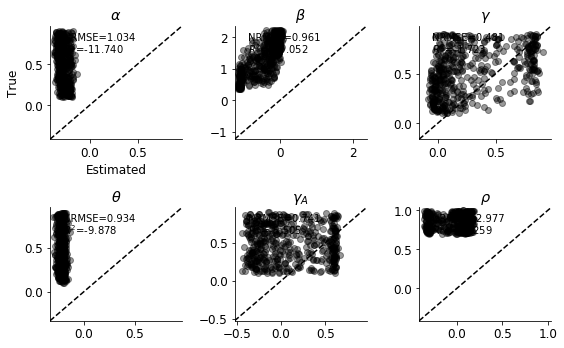

In [326]:
plot_true_est_scatter(model, test_data['x'], test_data['theta'], 
                      n_samples_posterior, param_names, figsize=(8, 5))

## Manage checkpoints

In [320]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=3)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


# Train networks

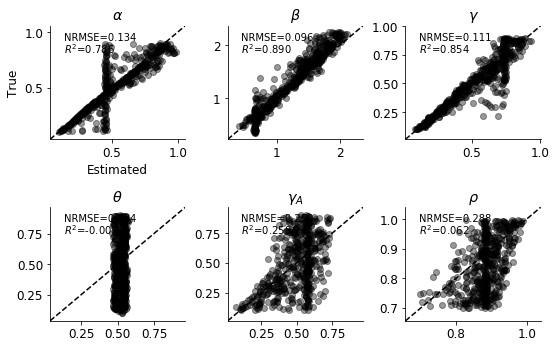

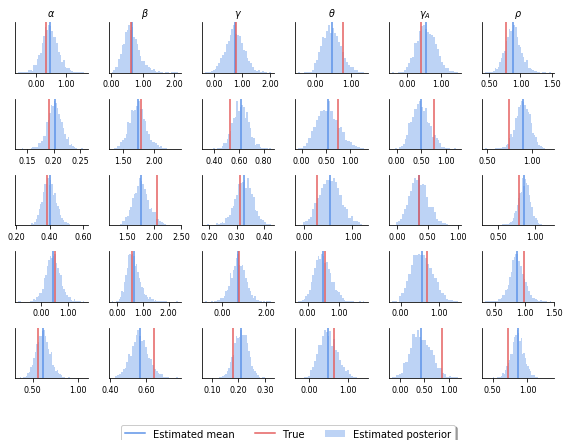

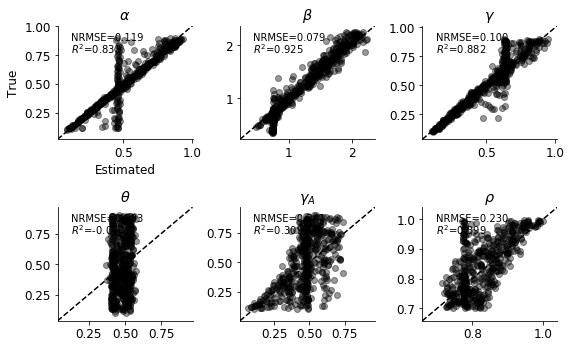

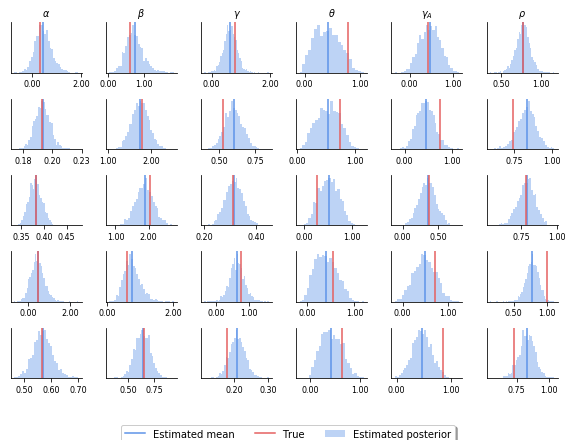

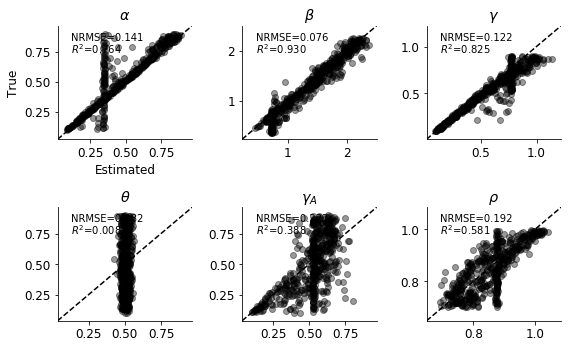

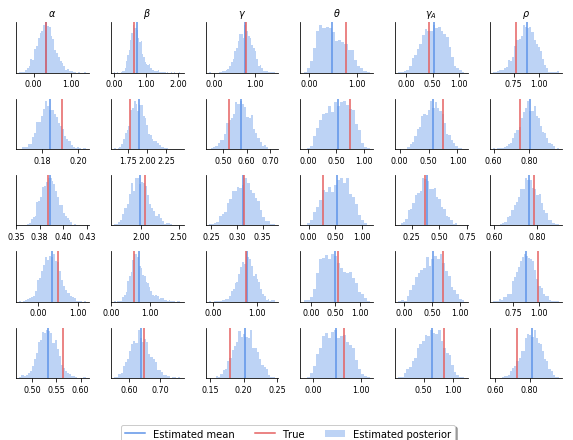

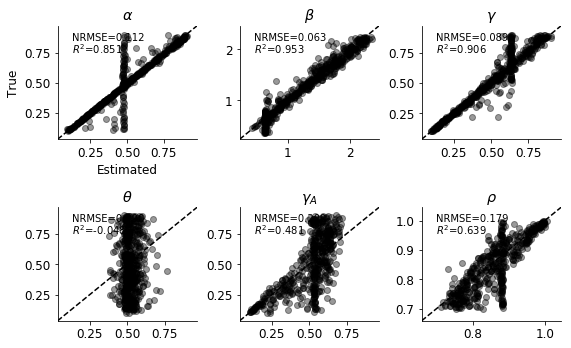

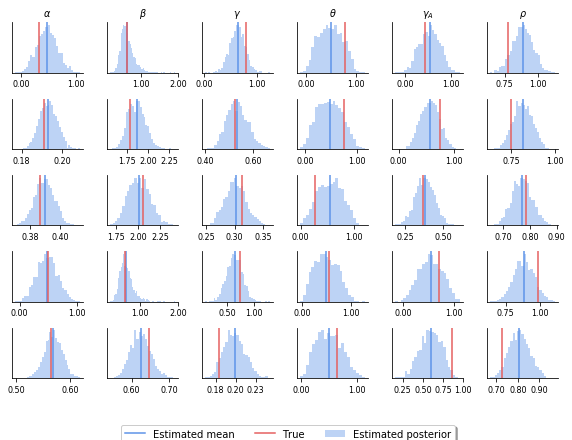

Instructions for updating:
Use standard file APIs to delete files with this prefix.



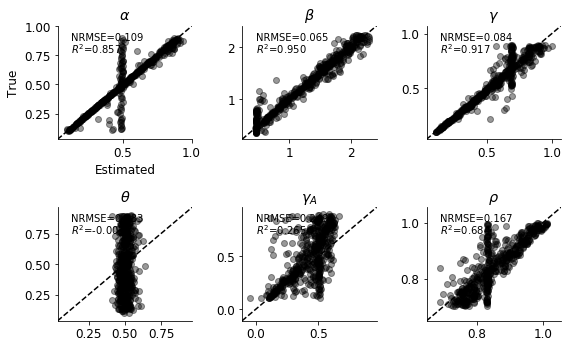

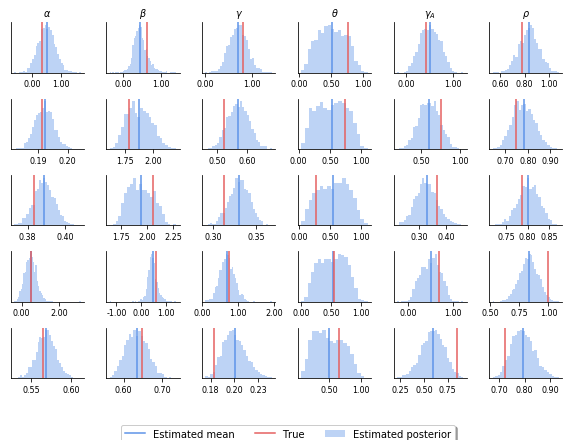

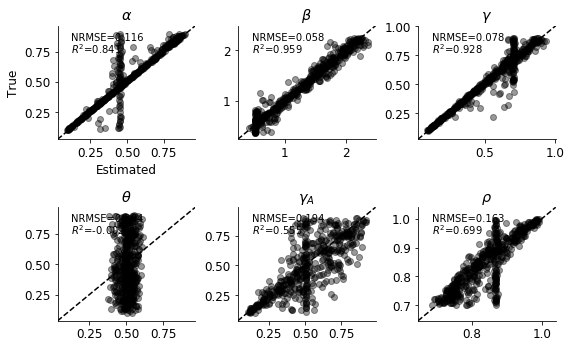

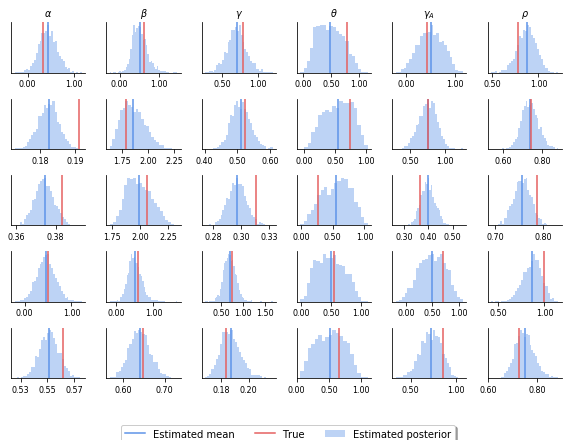

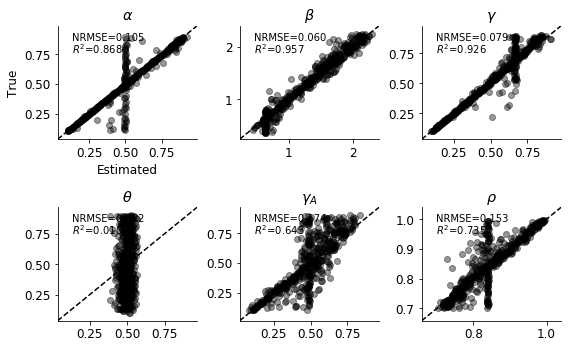

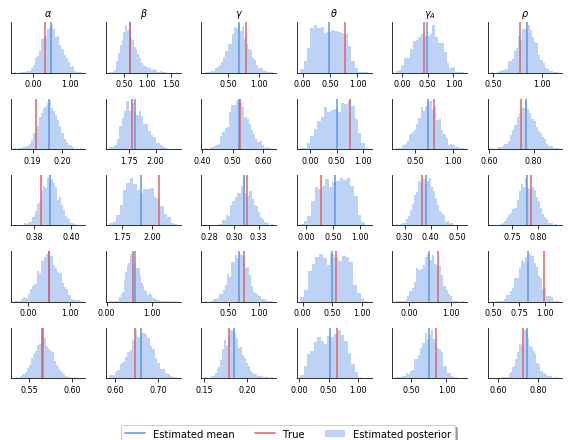

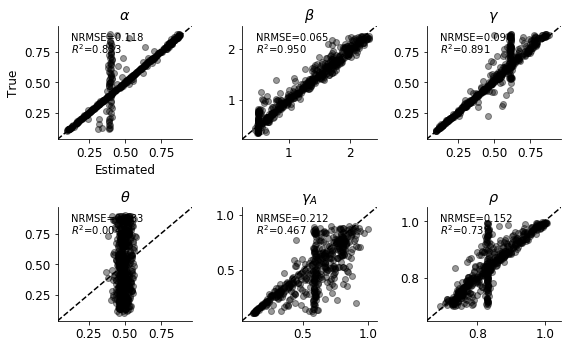

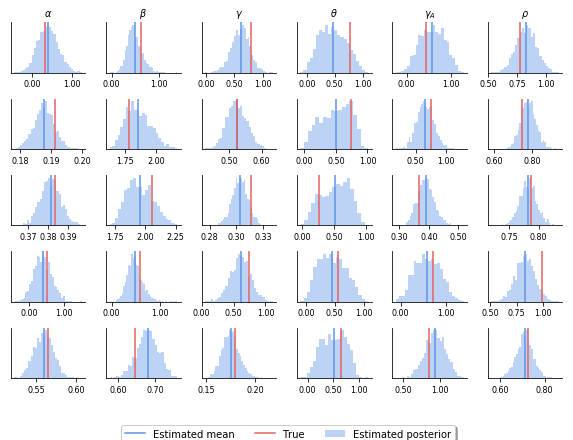

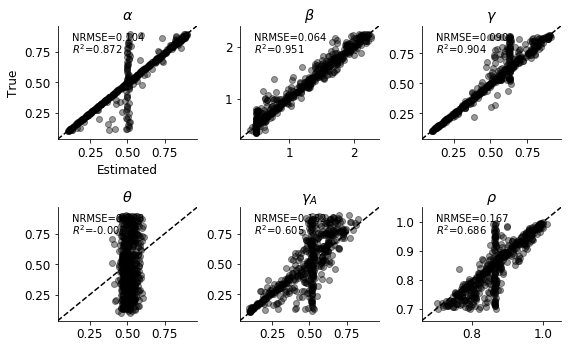

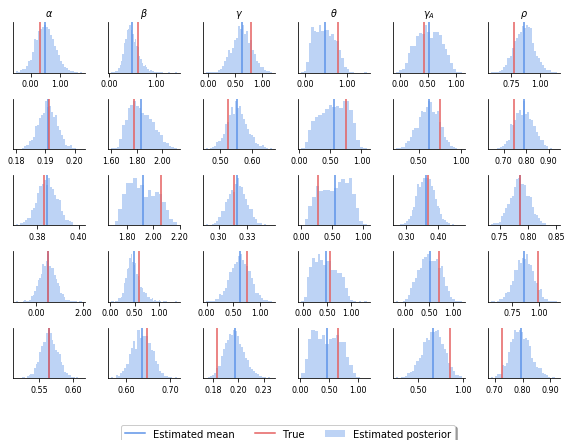

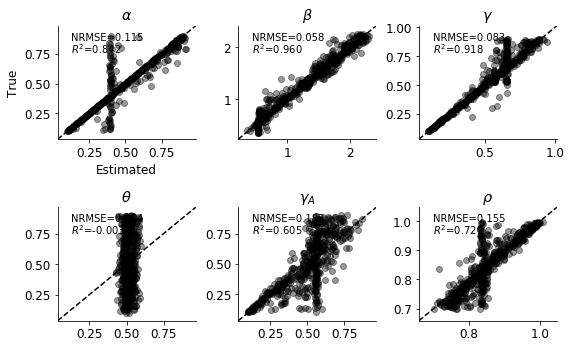

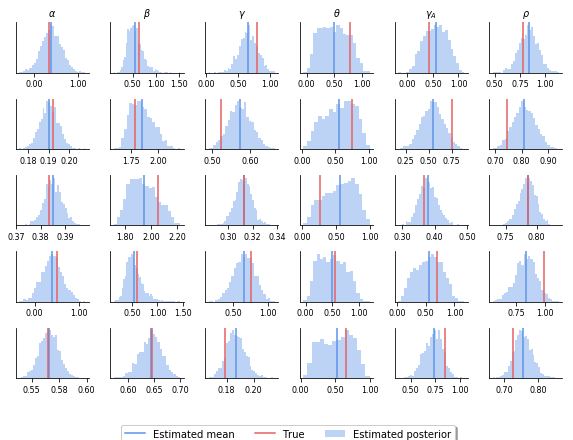

KeyboardInterrupt: 

In [328]:
%%time
for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_online(model=model, 
                              optimizer=optimizer, 
                              data_gen=data_generator, 
                              loss_fun=maximum_likelihood_loss, 
                              iterations=iterations_per_epoch,
                              batch_size=batch_size,
                              p_bar=p_bar,
                              clip_value=clip_value,
                              clip_method='value',
                              global_step=global_step)
        
        plot_true_est_scatter(model, test_data['x'], test_data['theta'], 
                      n_samples_posterior, param_names, figsize=(8, 5))
        
        plot_true_est_posterior(model, 2000, param_names, font_size=8,
                        X_test=test_data['x'][:5], 
                        theta_test=test_data['theta'][:5], figsize=(8, 6))

        # Manage checkpoint
        manager.save()

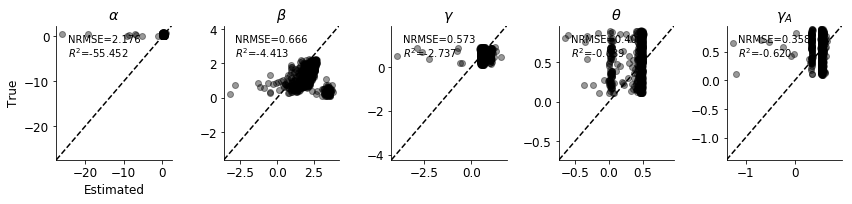

In [240]:
plot_true_est_scatter(model, test_data['x'], test_data['theta'], 
                      n_samples_posterior, param_names, figsize=(12, 3))